In [16]:
print("hello")
from datetime import datetime
import os
import pandas as pd
from datetime import datetime, timezone, timedelta
import pytz
import re
import numpy as np
import logging
import catboost

from catboost import CatBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

hello


In [2]:
df = pd.read_parquet('CLEANED_V9.1.parquet', engine='pyarrow')

In [3]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'STD_temp_scaled', 'STD_dwpt_scaled', 'STD_rhum_scaled',
       'STD_prcp_scaled', 'STD_snow_scaled', 'STD_wdir_scaled',
       'STD_wspd_scaled', 'STD_wpgt_scaled', 'STD_pres_scaled',
       'STD_tsun_scaled', 'STD_coco_scaled', 'STA_temp_scaled',
       'STA_dwpt_scaled', 'STA_rhum_scaled', 'STA_prcp_scaled',
       'STA_snow_scaled', 'STA_wdir_scaled', 'STA_wspd_scaled',
       'STA_wpgt_scaled', 'STA_pres_scaled', 'STA_tsun_scaled',
       'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'final_pred_dep', 'Y_arrival'],
      dtype='object')


In [4]:
df = df.drop(columns = ["final_pred_dep"])

# CatBoost Base Model

In [5]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'STD_temp_scaled', 'STD_dwpt_scaled', 'STD_rhum_scaled',
       'STD_prcp_scaled', 'STD_snow_scaled', 'STD_wdir_scaled',
       'STD_wspd_scaled', 'STD_wpgt_scaled', 'STD_pres_scaled',
       'STD_tsun_scaled', 'STD_coco_scaled', 'STA_temp_scaled',
       'STA_dwpt_scaled', 'STA_rhum_scaled', 'STA_prcp_scaled',
       'STA_snow_scaled', 'STA_wdir_scaled', 'STA_wspd_scaled',
       'STA_wpgt_scaled', 'STA_pres_scaled', 'STA_tsun_scaled',
       'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'Y_arrival'],
      dtype='object')


In [6]:
cat_cols = [col for col in df.columns if df[col].dtype.name == 'category']
print(cat_cols)

['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code', 'Mode S', 'Serial Number', 'FROM', 'TO']


In [7]:
for col in df.select_dtypes(include=['category']).columns:
    if 'missing' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('missing')
    df[col] = df[col].fillna('missing')

In [8]:
X = df.drop('Y_arrival', axis=1)
y = df['Y_arrival']

In [9]:
# First split: separating test set (20% of total data)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: separating validation set from the training set (25% of 80% = 20% of total data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 7001871
Validation set size: 2333958
Test set size: 2333958


## Baseline Model

In [10]:
# Initialize and train the CatBoost Classifier with validation set
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_cols,
    verbose=True
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6382828	test: 0.6388782	best: 0.6388782 (0)	total: 4.36s	remaining: 7m 11s
1:	learn: 0.6353425	test: 0.6356880	best: 0.6388782 (0)	total: 6.12s	remaining: 4m 59s
2:	learn: 0.6448846	test: 0.6455446	best: 0.6455446 (2)	total: 7.59s	remaining: 4m 5s
3:	learn: 0.6449012	test: 0.6453964	best: 0.6455446 (2)	total: 8.84s	remaining: 3m 32s
4:	learn: 0.6450949	test: 0.6456114	best: 0.6456114 (4)	total: 9.98s	remaining: 3m 9s
5:	learn: 0.6473361	test: 0.6478955	best: 0.6478955 (5)	total: 11.1s	remaining: 2m 53s
6:	learn: 0.6509453	test: 0.6515092	best: 0.6515092 (6)	total: 12.3s	remaining: 2m 43s
7:	learn: 0.6514467	test: 0.6519967	best: 0.6519967 (7)	total: 13.4s	remaining: 2m 33s
8:	learn: 0.6519983	test: 0.6526274	best: 0.6526274 (8)	total: 14.5s	remaining: 2m 26s
9:	learn: 0.6512776	test: 0.6519162	best: 0.6526274 (8)	total: 15.5s	remaining: 2m 19s
10:	learn: 0.6512754	test: 0.6520014	best: 0.6526274 (8)	total: 16.7s	remaining: 2m 15s
11:	learn: 0.6519904	test: 0.6525923	best: 0

In [11]:
# Model evaluation
predictions = model.predict(X_test)
accuracy = (predictions.flatten() == y_test).mean()
print(f"Test set accuracy: {accuracy}")


Test set accuracy: 0.6759376132732465


In [12]:
# Predict and calculate metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)  # Ensure binary format if necessary

accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.68
F1 Score: 0.40
Precision: 0.65
Recall: 0.29


In [13]:
conf_matrix = confusion_matrix(y_test, predictions_binary)

In [14]:
conf_matrix

array([[1326866,  137007],
       [ 619341,  250744]], dtype=int64)

##  Feature Importance

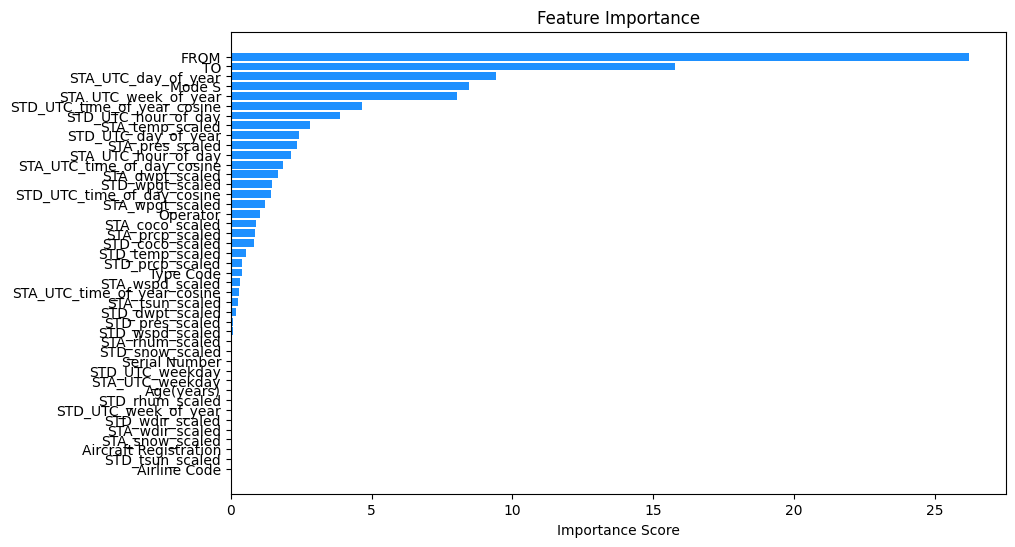

In [17]:
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame to hold feature names and their importance scores
importances = pd.DataFrame({
    'Feature Names': feature_names,
    'Importance Scores': feature_importances
})

# Sort the DataFrame by importance scores in descending order
importances = importances.sort_values(by='Importance Scores', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature Names'], importances['Importance Scores'], color='dodgerblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the most important at the top
plt.show()

In [18]:
print(importances)

                  Feature Names  Importance Scores
7                          FROM          26.213035
8                            TO          15.773836
39          STA_UTC_day_of_year           9.418532
4                        Mode S           8.444653
40         STA_UTC_week_of_year           8.042679
32  STD_UTC_time_of_year_cosine           4.661211
36          STD_UTC_hour_of_day           3.883760
20              STA_temp_scaled           2.824312
33          STD_UTC_day_of_year           2.407676
28              STA_pres_scaled           2.362236
42          STA_UTC_hour_of_day           2.140853
37   STA_UTC_time_of_day_cosine           1.862551
21              STA_dwpt_scaled           1.662077
16              STD_wpgt_scaled           1.466833
31   STD_UTC_time_of_day_cosine           1.435445
27              STA_wpgt_scaled           1.213784
2                      Operator           1.022207
30              STA_coco_scaled           0.881802
23              STA_prcp_scaled

In [19]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'STD_temp_scaled', 'STD_dwpt_scaled', 'STD_rhum_scaled',
       'STD_prcp_scaled', 'STD_snow_scaled', 'STD_wdir_scaled',
       'STD_wspd_scaled', 'STD_wpgt_scaled', 'STD_pres_scaled',
       'STD_tsun_scaled', 'STD_coco_scaled', 'STA_temp_scaled',
       'STA_dwpt_scaled', 'STA_rhum_scaled', 'STA_prcp_scaled',
       'STA_snow_scaled', 'STA_wdir_scaled', 'STA_wspd_scaled',
       'STA_wpgt_scaled', 'STA_pres_scaled', 'STA_tsun_scaled',
       'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'Y_arrival'],
      dtype='object')
